# Building ML model

## Probability calibration

## Content

- Why do we need it?

- Calibration curves

- Calibration techniques

When performing classification you often want not only to predict the class label, but also obtain a probability of the respective label. This probability gives you some kind of confidence on the prediction. Some models can give you poor estimates of the class probabilities and some even do not support probability prediction (e.g., some instances of SGDClassifier). The calibration module allows you to better calibrate the probabilities of a given model, or to add support for probability prediction.

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance, a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to, say, 0.8, approximately 80% actually belong to the positive class.

Before we show how to re-calibrate a classifier, we first need a way to detect how good a classifier is calibrated.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from scipy.special import expit

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14})

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data.csv')
data.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Scale the data and split it into train and test.

In [12]:
X = data.drop(columns=['id', 'Class'])
y = data.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=999)
scaler = StandardScaler().fit(X_train, y_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
print('Class balance:', y.mean())

Class balance: 0.5490789111905416


Classes are balanced. 

Let's fit the Support Vector Classification and Logistic Regression, quality metric is ROC-AUC. 
We will consider the output of `decision_function` as scores, which are proportional to the signed
distance of that sample to the hyperplane.

#### Task: Predict confidence scores for logistic regression and for SVC.
`Hint`: use decision_function

In [14]:
svc = LinearSVC(max_iter=100000, C=0.1).fit(X_train, y_train)
svc_pred = pass

print('SVC ROC-AUC:', roc_auc_score(y_test, svc_pred))

SVC ROC-AUC: 0.9991458548930181


In [15]:
lr = LogisticRegression(max_iter=100000, C=0.1).fit(X_train, y_train)
lr_pred = pass

print('Logistic regression ROC-AUC:', roc_auc_score(y_test, lr_pred))

Logistic regression ROC-AUC: 0.9990037517667494


ROC-AUC tells us that we ideally predict the target variable. Let's look at our scores distirbution for test dataset.

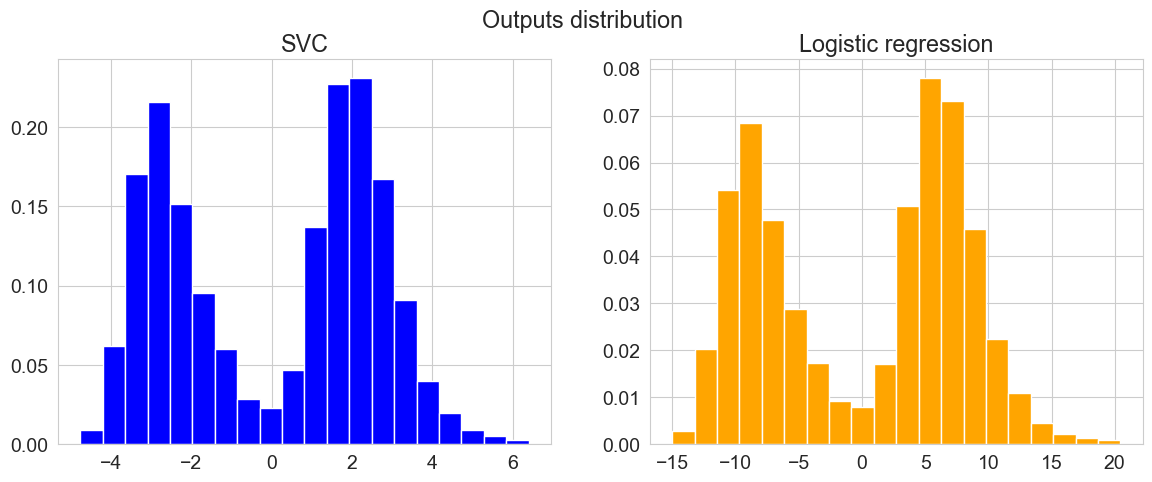

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].hist(svc_pred, bins=20, color='blue', density='True')
axs[1].hist(lr_pred, bins=20, color='orange', density='True')

axs[0].set_title('SVC')
axs[1].set_title('Logistic regression')

plt.suptitle('Outputs distribution')
plt.show()

We could see that scores could take any real values. To estimate the probabilities, we need to convert them into the range $[0, 1]$. 

For logistic regression we could just use sigmoid function as long as the model was trained so that the value of $\sigma\big(\langle w, x\rangle + b\big)$ approximated the probabilities.

For SVC we don't have such option, therefore, we will use min-max scaling.

#### Task: Do the min-max scaling for svc_pred and predict probabilities for logistic regression and plot them.

In [18]:
svc_pred = pass
lr_pred = pass

## Calibration curves

Calibration curves compare how well the probabilistic predictions of a binary classifier are calibrated. It plots the frequency of the positive label (to be more precise, an estimation of the conditional event probability $P(Y=1|predict_proba)$ on the y-axis against the predicted probability predict_proba of a model on the x-axis. 

The tricky part is to get values for the y-axis. In scikit-learn, this is accomplished by binning the predictions such that the x-axis represents the average predicted probability in each bin. The y-axis is then the fraction of positives given the predictions of that bin, i.e. the proportion of samples whose class is the positive class (in each bin).

#### Task: calculate calibration curves with 15 bins for both of the algorithms.

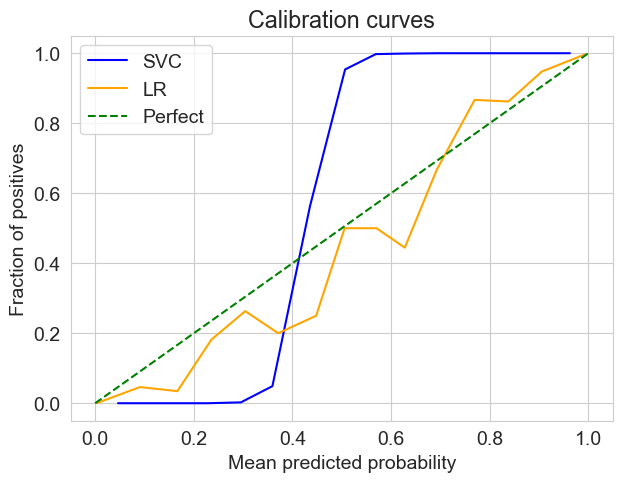

In [22]:
plt.figure(figsize=(7, 5))

svc_true_prob, svc_pred_prob = pass
lr_true_prob, lr_pred_prob = pass

plt.plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
plt.plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
plt.plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curves')
plt.legend()
plt.show()

We see that the curve for logistic regression approximates the diagonal well. The same cannot be said about the SVC. Let's try to calibrate the classifiers and build new curves.

## Calibration techniques

Calibrating a classifier consists of fitting a regressor (called a calibrator) that maps the output of the classifier (as given by decision_function or predict_proba) to a calibrated probability in [0, 1]. 

The two most popular calibration methods are Platt’s logistic model (sigmoid) and isotonic regression. Both of these methods are implemented in [`sklearn`](https://scikit-learn.org/stable/modules/calibration.html#calibration).


**Platt’s logistic model**

Let's assume we have a trained classifier $b(x)$, which gives us confidence scores that $x$ belongs to a positive class. The method approximates the probability of a positive class using a sigmoid function:

$$
p\big(y = +1 \big| b(x)\big) = \frac{1}{1 + \exp (A \cdot b(x) + C)}
$$

Here the trainable parameters are $A, C\in\mathbb{R}$, they are trained using the maximum likelihood method (just like in logistic regression). This can be done by cross-validation or with validation datasets.

**Isotonic regression**

Another method uses the so-called isotonic function &mdash; piecewise linear increasing function $f:\mathbb{R}\rightarrow\mathbb{R}$. We want to find the with respect to MSE minimization:

$$
\frac{1}{\ell} \sum_{i=1}^\ell \big(y_i - f(b(x_i))\big)^2 \rightarrow \min_f
$$

This method could overfit easily, so it is recommended to use it only for large datasets.

We will calibrate our predictions using cross-validation. Of course, it doesn't make much sense to calibrate the logistic regression, but we'll experiment a little.

#### Task: use both methods for SVC and Logistic Regression with 3-fold cross validation

`Hint`: CalibratedClassifierCV

In [11]:


sigmoid_svc_pred = pass
print('SVC ROC-AUC:', roc_auc_score(y_test, sigmoid_svc_pred))

SVC ROC-AUC: 0.9991339493679388


In [12]:

isotonic_svc_pred = pass
print('SVC ROC-AUC:', roc_auc_score(y_test, isotonic_svc_pred))

SVC ROC-AUC: 0.9990994157134615


In [13]:

sigmoid_lr_pred = pass
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, sigmoid_lr_pred))

Logistic regression ROC-AUC: 0.9989797117641851


In [14]:

isotonic_lr_pred = pass
print('Logistic regression ROC-AUC:', roc_auc_score(y_test, isotonic_lr_pred))

Logistic regression ROC-AUC: 0.9989480400147751


#### Task: calculate new caliration curves for Logistic Regression and SVC and compare your results

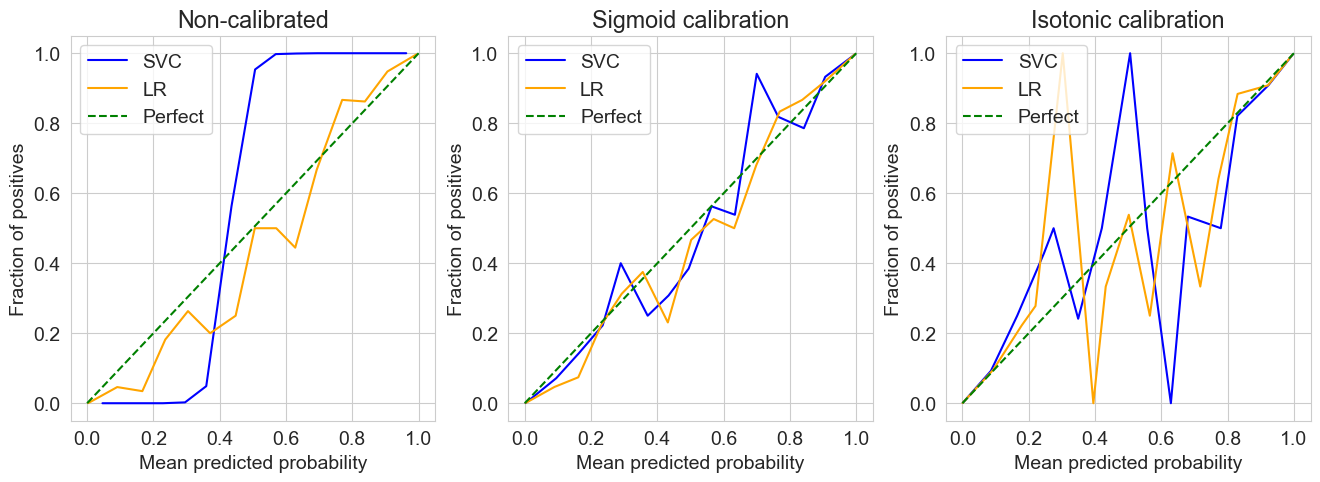

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Non-calibrated
svc_true_prob, svc_pred_prob = pass
lr_true_prob, lr_pred_prob = pass

axs[0].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[0].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[0].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[0].set_title('Non-calibrated')

# Sigmoid calibration
svc_true_prob, svc_pred_prob = pass
lr_true_prob, lr_pred_prob = pass

axs[1].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[1].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[1].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[1].set_title('Sigmoid calibration')

# Isotonic calibration
svc_true_prob, svc_pred_prob = pass
lr_true_prob, lr_pred_prob = pass

axs[2].plot(svc_pred_prob, svc_true_prob, label='SVC', color='blue')
axs[2].plot(lr_pred_prob, lr_true_prob, label='LR', color='orange')
axs[2].plot([0, 1], [0, 1], label='Perfect', linestyle='--', color='green')
axs[2].set_title('Isotonic calibration')

for ax in axs:
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()

plt.show()

The Platt's calibration has really improved the probabilities that are obtained from the SVC. At the same time, the curve for logistic regression practically does not shift. At the same time, isotonic regression has made things worse. Apparently, this method overfitted.